<a href="https://colab.research.google.com/github/Usman-938/Assignments/blob/main/Word_Embeddings_Amazon_Reviews_v2_Week_5_(D2)_Home_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛒 Word Embeddings: Word2Vec, GloVe & Semantic Analysis
### Amazon Fine Food Reviews — Class Assignment

| Part | Topic |
|------|-------|
| A | Data Preparation |
| B | Text Preprocessing |
| C | Train Word2Vec (CBOW + Skip-gram) |
| D | GloVe Embeddings + Analogy Tests |
| E | Cosine Similarity & Review Search Engine |
| F | K-Means Clustering + PCA Visualization |

---
## ⚡ Quick Start
**You need `Reviews.csv` from Kaggle before running.**

**Option 1 – Kaggle API:** Run the *Kaggle Setup* cell below (uploads `kaggle.json` automatically).  
**Option 2 – Manual:** Download `Reviews.csv` from the Kaggle link, upload to Colab via the 📁 sidebar, then skip the Kaggle Setup cell.

---
## 🔧 0. Install & Import

In [21]:
# ── Install packages (run once) ───────────────────────────────────────
!pip install gensim nltk scikit-learn matplotlib seaborn pandas numpy -q
print("✅ All packages installed")

✅ All packages installed


In [22]:
import pandas as pd
import numpy as np
import re
import os
import time
import zipfile
import urllib.request
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity as sk_cosine
from sklearn.preprocessing import LabelEncoder

# Download NLTK data
for resource in ['stopwords', 'punkt', 'punkt_tab', 'wordnet', 'omw-1.4']:
    nltk.download(resource, quiet=True)

print("✅ All imports successful!")
print(f"   Gensim version: {__import__('gensim').__version__}")
print(f"   NLTK version  : {nltk.__version__}")

✅ All imports successful!
   Gensim version: 4.4.0
   NLTK version  : 3.9.1


## 📥 Kaggle Setup (skip if manually uploading Reviews.csv)

In [23]:
# The dataset has been provided, so Kaggle setup is skipped.

---
## Part A – Data Preparation

In [24]:
# ── A1. Load Reviews.csv ──────────────────────────────────────────────
REVIEW_FILE = None
for path in ['Reviews.csv', 'amazon-fine-food-reviews/Reviews.csv', 'reviews.csv']:
    if os.path.exists(path):
        REVIEW_FILE = path
        break

if REVIEW_FILE is None:
    raise FileNotFoundError(
        "Reviews.csv not found. Please:\n"
        "  Option 1: Run the Kaggle Setup cell above, OR\n"
        "  Option 2: Upload Reviews.csv manually via the 📁 sidebar."
    )

print(f"Loading: {REVIEW_FILE}")
raw = pd.read_csv(REVIEW_FILE, usecols=['Text', 'Score'])
print(f"✅ Raw dataset loaded: {raw.shape[0]:,} rows")

Loading: Reviews.csv
✅ Raw dataset loaded: 568,454 rows


In [25]:
# ── A2. Select 5,000 reviews & create sentiment labels ───────────────
df = raw.dropna(subset=['Text', 'Score']).copy()
df['Score'] = df['Score'].astype(int)

# Stratified sample to maintain class proportions
N = 5000
df = (df.groupby('Score', group_keys=False)
        .apply(lambda g: g.sample(min(len(g), int(np.ceil(N * len(g) / len(df)))), random_state=42))
        .sample(n=min(N, len(df)), random_state=42)
        .reset_index(drop=True))

# Sentiment labels
def label_sentiment(score):
    if score >= 4: return 'Positive'
    if score == 3: return 'Neutral'
    return 'Negative'

df['Sentiment'] = df['Score'].apply(label_sentiment)

print(f"📐 Dataset shape : {df.shape}")
print(f"   Columns       : {list(df.columns)}")
print("\n⭐ Score distribution:")
print(df['Score'].value_counts().sort_index().to_string())
print("\n🏷️  Sentiment distribution:")
print(df['Sentiment'].value_counts().to_string())

📐 Dataset shape : (5000, 3)
   Columns       : ['Score', 'Text', 'Sentiment']

⭐ Score distribution:
Score
1     460
2     262
3     375
4     710
5    3193

🏷️  Sentiment distribution:
Sentiment
Positive    3903
Negative     722
Neutral      375


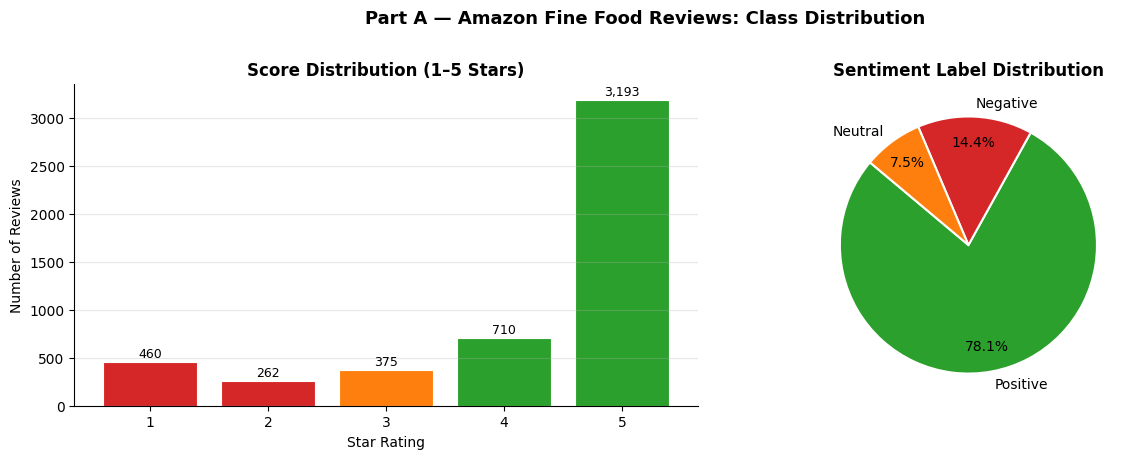

💾 Saved: class_distribution.png


In [26]:
# ── A3. Visualize class distribution ─────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))
fig.suptitle('Part A — Amazon Fine Food Reviews: Class Distribution',
             fontsize=13, fontweight='bold', y=1.01)

# Score bar chart
score_colors = ['#d62728','#d62728','#ff7f0e','#2ca02c','#2ca02c']
sc = df['Score'].value_counts().sort_index()
bars = axes[0].bar(sc.index, sc.values, color=score_colors, edgecolor='white', linewidth=0.8)
axes[0].set_title('Score Distribution (1–5 Stars)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Star Rating', fontsize=10)
axes[0].set_ylabel('Number of Reviews', fontsize=10)
axes[0].set_xticks([1,2,3,4,5])
for bar in bars:
    axes[0].text(bar.get_x()+bar.get_width()/2, bar.get_height()+10,
                 f'{int(bar.get_height()):,}', ha='center', va='bottom', fontsize=9)
axes[0].grid(axis='y', alpha=0.3)
axes[0].spines[['top','right']].set_visible(False)

# Sentiment pie chart
sent_counts = df['Sentiment'].value_counts()
sent_palette = {'Positive':'#2ca02c','Neutral':'#ff7f0e','Negative':'#d62728'}
colors_pie = [sent_palette[s] for s in sent_counts.index]
wedges, texts, autotexts = axes[1].pie(
    sent_counts.values, labels=sent_counts.index,
    autopct='%1.1f%%', colors=colors_pie,
    startangle=140, pctdistance=0.8,
    wedgeprops={'edgecolor':'white','linewidth':1.5})
for at in autotexts: at.set_fontsize(10)
axes[1].set_title('Sentiment Label Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 Saved: class_distribution.png")

---
## Part B – Text Preprocessing

In [27]:
# ── B1. Preprocessing pipeline ───────────────────────────────────────
STOP_WORDS  = set(stopwords.words('english'))
LEMMATIZER  = WordNetLemmatizer()

def preprocess(text: str) -> list:
    """Full preprocessing pipeline.
    Steps: lowercase → strip HTML → remove punct/nums
           → tokenize → remove stopwords → lemmatize
    """
    text = str(text).lower()
    text = re.sub(r'<[^>]+>', ' ', text)          # strip HTML tags
    text = re.sub(r'[^a-z\s]', ' ', text)         # remove punct & numbers
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    tokens = [
        LEMMATIZER.lemmatize(t)
        for t in tokens
        if t not in STOP_WORDS and len(t) >= 2
    ]
    return tokens

print("⏳ Preprocessing reviews (may take ~30 s)...")
t0 = time.time()
df['Tokens_raw'] = df['Text'].apply(preprocess)   # before freq filter
print(f"✅ Done in {time.time()-t0:.1f}s")

⏳ Preprocessing reviews (may take ~30 s)...
✅ Done in 12.4s


In [28]:
# ── B2. Vocabulary report (before freq filter) ────────────────────────
all_tokens_before = [t for toks in df['Tokens_raw'] for t in toks]
vocab_before      = set(all_tokens_before)

# Remove tokens with freq < 5
freq = Counter(all_tokens_before)
df['Tokens'] = df['Tokens_raw'].apply(
    lambda toks: [t for t in toks if freq[t] >= 5]
)

# Drop reviews that become empty after filtering
df = df[df['Tokens'].map(len) > 0].reset_index(drop=True)

all_tokens_after = [t for toks in df['Tokens'] for t in toks]
vocab_after      = set(all_tokens_after)

print("=" * 56)
print("  VOCABULARY REPORT")
print("=" * 56)
print(f"  Total token count  (before) : {len(all_tokens_before):>10,}")
print(f"  Unique tokens      (before) : {len(vocab_before):>10,}")
print(f"  Unique tokens      (after)  : {len(vocab_after):>10,}")
print(f"  Tokens removed (freq < 5)   : {len(vocab_before)-len(vocab_after):>10,}")
print(f"  Reviews retained            : {len(df):>10,}")
print("=" * 56)

  VOCABULARY REPORT
  Total token count  (before) :    194,912
  Unique tokens      (before) :     12,470
  Unique tokens      (after)  :      3,852
  Tokens removed (freq < 5)   :      8,618
  Reviews retained            :      5,000


In [29]:
# ── B3. Show 3 before / after examples ───────────────────────────────
print("=" * 72)
print("  3 BEFORE / AFTER PREPROCESSING EXAMPLES")
print("=" * 72)
for i in range(3):
    row = df.iloc[i]
    print(f"\n─── Example {i+1}  |  Sentiment: {row['Sentiment']}  |  Score: {row['Score']} ───")
    orig = str(row['Text'])
    print(f"BEFORE ({len(orig)} chars):")
    print(f"  {orig[:350]}{'...' if len(orig)>350 else ''}")
    print(f"AFTER  ({len(row['Tokens'])} tokens):")
    print(f"  {row['Tokens'][:25]}")

# Save cleaned dataset
df[['Text','Score','Sentiment']].to_csv('cleaned_reviews.csv', index=False)
print("\n💾 Saved: cleaned_reviews.csv")

  3 BEFORE / AFTER PREPROCESSING EXAMPLES

─── Example 1  |  Sentiment: Positive  |  Score: 4 ───
BEFORE (797 chars):
  I've tried a number of protein powders over the years.  Most problems I encountered ranged from poor taste, to not mixing well, to leaving me bloated.  The Healthy n Fit egg protein is only 100 calories and you get 24 grams of protein with no cholesterol, no fat, no carbs, minimal sodium (in the big scheme of things) and even some potassium.  Add t...
AFTER  (68 tokens):
  ['tried', 'number', 'protein', 'powder', 'year', 'problem', 'poor', 'taste', 'mixing', 'well', 'leaving', 'bloated', 'healthy', 'fit', 'egg', 'protein', 'calorie', 'get', 'gram', 'protein', 'cholesterol', 'fat', 'carbs', 'minimal', 'sodium']

─── Example 2  |  Sentiment: Positive  |  Score: 5 ───
BEFORE (442 chars):
  What can I say? It was my first real introduction to Indian 'prepared foods/mixes'...and it was GREAT!! Butter Chicken Curry ROCKS! Highly recommend the 'Kitchens of India' multi-packs

---
## Part C – Train Word2Vec Models

In [30]:
# ── C1. Prepare sentence corpus ───────────────────────────────────────
sentences = df['Tokens'].tolist()
print(f"Corpus: {len(sentences):,} documents | "
      f"Total tokens: {sum(len(s) for s in sentences):,}")

Corpus: 5,000 documents | Total tokens: 180,967


In [31]:
# ── C2. Model 1 — CBOW ───────────────────────────────────────────────
print("Training Model 1: CBOW  (vector_size=100, window=5, sg=0)...")
t0 = time.time()
model_cbow = Word2Vec(
    sentences   = sentences,
    vector_size = 100,
    window      = 5,
    min_count   = 5,
    sg          = 0,
    workers     = 4,
    epochs      = 10,
    seed        = 42
)
cbow_time = time.time() - t0
model_cbow.save('cbow_model.model')
print(f"✅ CBOW trained in {cbow_time:.2f}s  |  vocab: {len(model_cbow.wv):,}")

Training Model 1: CBOW  (vector_size=100, window=5, sg=0)...
✅ CBOW trained in 6.38s  |  vocab: 3,852


In [32]:
# ── C3. Model 2 — Skip-gram ───────────────────────────────────────────
print("Training Model 2: Skip-gram  (vector_size=200, window=8, sg=1)...")
t0 = time.time()
model_sg = Word2Vec(
    sentences   = sentences,
    vector_size = 200,
    window      = 8,
    min_count   = 5,
    sg          = 1,
    workers     = 4,
    epochs      = 10,
    seed        = 42
)
sg_time = time.time() - t0
model_sg.save('skipgram_model.model')
print(f"✅ Skip-gram trained in {sg_time:.2f}s  |  vocab: {len(model_sg.wv):,}")

Training Model 2: Skip-gram  (vector_size=200, window=8, sg=1)...
✅ Skip-gram trained in 29.07s  |  vocab: 3,852


In [33]:
# ── C4. Training time comparison table ───────────────────────────────
print("\n" + "=" * 62)
print("  MODEL TRAINING COMPARISON")
print("=" * 62)
print(f"  {'Attribute':<26} {'CBOW (M1)':>14} {'Skip-gram (M2)':>16}")
print(f"  {'-'*58}")
print(f"  {'Algorithm':<26} {'CBOW':>14} {'Skip-gram':>16}")
print(f"  {'vector_size':<26} {'100':>14} {'200':>16}")
print(f"  {'window':<26} {'5':>14} {'8':>16}")
print(f"  {'epochs':<26} {'10':>14} {'10':>16}")
print(f"  {'Vocabulary':<26} {len(model_cbow.wv):>14,} {len(model_sg.wv):>16,}")
print(f"  {'Training time (s)':<26} {cbow_time:>14.2f} {sg_time:>16.2f}")
speedup = sg_time / cbow_time if cbow_time > 0 else 0
print(f"  {'Relative speed':<26} {'1.0x':>14} {speedup:>15.1f}x")
print("=" * 62)
print("\n💡 Skip-gram trains slower but captures rare word contexts better.")
print("   CBOW is faster and strong for frequent, common words.")


  MODEL TRAINING COMPARISON
  Attribute                       CBOW (M1)   Skip-gram (M2)
  ----------------------------------------------------------
  Algorithm                            CBOW        Skip-gram
  vector_size                           100              200
  window                                  5                8
  epochs                                 10               10
  Vocabulary                          3,852            3,852
  Training time (s)                    6.38            29.07
  Relative speed                       1.0x             4.6x

💡 Skip-gram trains slower but captures rare word contexts better.
   CBOW is faster and strong for frequent, common words.


In [34]:
# ── C5. Most similar words comparison ────────────────────────────────
keywords = ['food', 'taste', 'quality', 'price', 'love', 'fresh', 'sweet']

print("=" * 76)
print("  TOP-10 SIMILAR WORDS: CBOW (M1) vs Skip-gram (M2)")
print("=" * 76)

for kw in keywords:
    in_cbow = kw in model_cbow.wv
    in_sg   = kw in model_sg.wv
    if not in_cbow and not in_sg:
        print(f"\n⚠️  '{kw}' not found in either model vocab — skipping")
        continue
    print(f"\n🔑 Keyword: '{kw}'")
    print(f"  {'Rank':<5} {'CBOW':^33} {'Skip-gram':^33}")
    print(f"  {'─'*71}")
    cbow_res = model_cbow.wv.most_similar(kw, topn=10) if in_cbow else []
    sg_res   = model_sg.wv.most_similar(kw, topn=10)   if in_sg   else []
    for i in range(10):
        c = f"{cbow_res[i][0]:<18} ({cbow_res[i][1]:.4f})" if i < len(cbow_res) else " " * 28
        s = f"{sg_res[i][0]:<18} ({sg_res[i][1]:.4f})"   if i < len(sg_res)   else ""
        print(f"  {i+1:<5} {c:<33} {s}")

  TOP-10 SIMILAR WORDS: CBOW (M1) vs Skip-gram (M2)

🔑 Keyword: 'food'
  Rank                CBOW                            Skip-gram            
  ───────────────────────────────────────────────────────────────────────
  1     feed               (0.9309)       halo               (0.7134)
  2     canned             (0.9214)       evo                (0.6998)
  3     cat                (0.9201)       feed               (0.6971)
  4     wellness           (0.9011)       wellness           (0.6919)
  5     pet                (0.8979)       fed                (0.6864)
  6     baby               (0.8873)       wet                (0.6794)
  7     allergy            (0.8833)       bff                (0.6787)
  8     feeding            (0.8828)       innova             (0.6727)
  9     health             (0.8809)       core               (0.6678)
  10    wet                (0.8758)       refuse             (0.6671)

🔑 Keyword: 'taste'
  Rank                CBOW                            Skip-

---
## Part D – GloVe Embeddings

In [35]:
# ── D1. Download & load GloVe 6B.100d ────────────────────────────────
GLOVE_URL  = 'https://nlp.stanford.edu/data/glove.6B.zip'
GLOVE_ZIP  = 'glove.6B.zip'
GLOVE_FILE = 'glove.6B.100d.txt'

if not os.path.exists(GLOVE_FILE):
    print(f"⏬ Downloading GloVe (~822 MB) — please wait...")
    def reporthook(count, block_size, total_size):
        pct = int(count * block_size * 100 / total_size)
        if count % 500 == 0:
            print(f"   Progress: {pct}%", end='\r')
    urllib.request.urlretrieve(GLOVE_URL, GLOVE_ZIP, reporthook)
    print("\n📦 Extracting glove.6B.100d.txt ...")
    with zipfile.ZipFile(GLOVE_ZIP, 'r') as z:
        z.extract(GLOVE_FILE)
    print("✅ GloVe file ready")
else:
    print(f"✅ GloVe already cached: {GLOVE_FILE}")

# Load vectors into dict
print("Loading GloVe vectors into memory...")
glove = {}
with open(GLOVE_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.split()
        glove[parts[0]] = np.array(parts[1:], dtype=np.float32)

print(f"✅ Loaded {len(glove):,} GloVe word vectors (100-dim)")

⏬ Downloading GloVe (~822 MB) — please wait...

📦 Extracting glove.6B.100d.txt ...
✅ GloVe file ready
Loading GloVe vectors into memory...
✅ Loaded 400,000 GloVe word vectors (100-dim)


In [36]:
# ── D2. Helper — GloVe most-similar (restricted to corpus vocab) ──────
CORPUS_VOCAB = vocab_after  # tokens that survived freq>=5 filter

# Precompute GloVe matrix for corpus words only (fast lookup)
glove_corpus_words = [w for w in CORPUS_VOCAB if w in glove]
glove_corpus_mat   = np.array([glove[w] for w in glove_corpus_words])
print(f"GloVe coverage over corpus vocab: {len(glove_corpus_words):,} / {len(CORPUS_VOCAB):,} words")

def glove_most_similar(word: str, topn: int = 10):
    if word not in glove:
        return []
    qvec = glove[word].reshape(1, -1)
    sims = sk_cosine(qvec, glove_corpus_mat)[0]
    top_idx = np.argsort(sims)[::-1]
    results = []
    for i in top_idx:
        w = glove_corpus_words[i]
        if w != word:
            results.append((w, float(sims[i])))
        if len(results) == topn:
            break
    return results

GloVe coverage over corpus vocab: 3,801 / 3,852 words


In [37]:
# ── D3. Word2Vec vs GloVe similarity comparison ───────────────────────
compare_kws = ['food', 'taste', 'quality', 'fresh', 'delicious']

print("=" * 76)
print("  WORD2VEC (CBOW) vs GloVe 6B.100d — TOP-5 SIMILAR WORDS")
print("=" * 76)

for kw in compare_kws:
    print(f"\n🔑 '{kw}'")
    print(f"  {'Rank':<5} {'Word2Vec CBOW':^32} {'GloVe 6B.100d':^32}")
    print(f"  {'─'*69}")
    w2v_res   = model_cbow.wv.most_similar(kw, topn=5) if kw in model_cbow.wv else []
    gl_res    = glove_most_similar(kw, topn=5)
    for i in range(5):
        c = f"{w2v_res[i][0]:<20}({w2v_res[i][1]:.4f})" if i < len(w2v_res) else " " * 30
        g = f"{gl_res[i][0]:<20}({gl_res[i][1]:.4f})"  if i < len(gl_res)  else ""
        print(f"  {i+1:<5} {c:<32} {g}")

  WORD2VEC (CBOW) vs GloVe 6B.100d — TOP-5 SIMILAR WORDS

🔑 'food'
  Rank           Word2Vec CBOW                    GloVe 6B.100d          
  ─────────────────────────────────────────────────────────────────────
  1     feed                (0.9309)     meat                (0.7138)
  2     canned              (0.9214)     supply              (0.6733)
  3     cat                 (0.9201)     feed                (0.6704)
  4     wellness            (0.9011)     coffee              (0.6628)
  5     pet                 (0.8979)     nutrition           (0.6551)

🔑 'taste'
  Rank           Word2Vec CBOW                    GloVe 6B.100d          
  ─────────────────────────────────────────────────────────────────────
  1     ginger              (0.8905)     flavor              (0.8360)
  2     aftertaste          (0.8686)     mix                 (0.7184)
  3     nothing             (0.8442)     delicious           (0.7034)
  4     sour                (0.8409)     blend               (0.6915)


In [38]:
# ── D4. Analogy tests (4 minimum) ────────────────────────────────────
def w2v_analogy(model, positive, negative, topn=3):
    missing = [w for w in positive + negative if w not in model.wv]
    if missing:
        return None, missing
    return model.wv.most_similar(positive=positive, negative=negative, topn=topn), []

def glove_analogy(positive, negative, topn=3):
    pos_vecs = [glove[w] for w in positive if w in glove]
    neg_vecs = [glove[w] for w in negative if w in glove]
    if not pos_vecs:
        return []
    qvec = np.sum(pos_vecs, axis=0) - (np.sum(neg_vecs, axis=0) if neg_vecs else 0)
    qvec = qvec.reshape(1, -1)
    exclude = set(positive + negative)
    valid_words = [w for w in glove_corpus_words if w not in exclude]
    valid_mat   = np.array([glove[w] for w in valid_words])
    sims = sk_cosine(qvec, valid_mat)[0]
    top_idx = np.argsort(sims)[::-1][:topn]
    return [(valid_words[i], float(sims[i])) for i in top_idx]

analogy_tests = [
    {
        'label'     : 'A1 — Flavor shift: "sweet" is to "sour" as "good" is to ?',
        'positive'  : ['sour', 'good'],
        'negative'  : ['sweet'],
    },
    {
        'label'     : 'A2 — Quality→Value: "tasty" − "food" + "price" = ?',
        'positive'  : ['tasty', 'price'],
        'negative'  : ['food'],
    },
    {
        'label'     : 'A3 — Antonym: "love" − "like" + "dislike" = ?',
        'positive'  : ['love', 'dislike'],
        'negative'  : ['like'],
    },
    {
        'label'     : 'A4 — Action: "buy" − "purchase" + "return" = ?',
        'positive'  : ['buy', 'return'],
        'negative'  : ['purchase'],
    },
    {
        'label'     : 'A5 — Sentiment: "great" − "bad" + "awful" = ?',
        'positive'  : ['great', 'awful'],
        'negative'  : ['bad'],
    },
]

print("=" * 72)
print("  ANALOGY TESTS  (A is to B as C is to ?)")
print("=" * 72)

for test in analogy_tests:
    print(f"\n🧪 {test['label']}")
    print(f"   positive={test['positive']}  negative={test['negative']}")

    for mname, model in [('CBOW (M1)', model_cbow), ('Skip-gram (M2)', model_sg)]:
        res, missing = w2v_analogy(model, test['positive'], test['negative'])
        if missing:
            print(f"   [{mname}] ⚠️  Not in vocab: {missing}")
        else:
            top = ', '.join([f"{w}({s:.3f})" for w, s in res])
            print(f"   [{mname}] → {top}")

    gl_res = glove_analogy(test['positive'], test['negative'])
    if gl_res:
        top = ', '.join([f"{w}({s:.3f})" for w, s in gl_res])
        print(f"   [GloVe 6B] → {top}")
    else:
        print("   [GloVe 6B] ⚠️  Words not found in GloVe vocab")

  ANALOGY TESTS  (A is to B as C is to ?)

🧪 A1 — Flavor shift: "sweet" is to "sour" as "good" is to ?
   positive=['sour', 'good']  negative=['sweet']
   [CBOW (M1)] → realistic(0.794), exactly(0.791), amazing(0.779)
   [Skip-gram (M2)] → worm(0.542), super(0.483), germany(0.476)
   [GloVe 6B] → better(0.651), bad(0.632), think(0.629)

🧪 A2 — Quality→Value: "tasty" − "food" + "price" = ?
   positive=['tasty', 'price']  negative=['food']
   [CBOW (M1)] → super(0.763), excellent(0.729), fresh(0.723)
   [Skip-gram (M2)] → amazingly(0.518), tho(0.499), economical(0.493)
   [GloVe 6B] → priced(0.497), attractive(0.489), ridiculously(0.483)

🧪 A3 — Antonym: "love" − "like" + "dislike" = ?
   positive=['love', 'dislike']  negative=['like']
   [CBOW (M1)] → household(0.878), deliver(0.870), fell(0.868)
   [Skip-gram (M2)] → assorted(0.601), lemony(0.585), household(0.570)
   [GloVe 6B] → desire(0.549), liking(0.534), bitterness(0.523)

🧪 A4 — Action: "buy" − "purchase" + "return" = ?
   posit

In [39]:
# ── D5. Discussion: Predictive vs Count-based ─────────────────────────
discussion = """
╔══════════════════════════════════════════════════════════════════════╗
║  PREDICTIVE (Word2Vec) vs COUNT-BASED (GloVe)                      ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  Word2Vec (Predictive)                                               ║
║  • Trains a shallow neural network to predict context (CBOW) or      ║
║    target word (Skip-gram) within a local sliding window.            ║
║  • Embeddings emerge as internal weight matrices.                    ║
║  • Efficient on large corpora; captures local syntactic patterns.    ║
║  • Domain-tuned: training on Amazon reviews captures review-         ║
║    specific language ('delicious', 'crunchy', 'overpriced').         ║
║                                                                      ║
║  GloVe (Count-based / Global)                                        ║
║  • Constructs a global co-occurrence matrix over the full corpus,    ║
║    then factorizes it with a weighted least-squares objective.        ║
║  • Captures global statistical word-word relationships.              ║
║  • Pretrained on Wikipedia + Gigaword (~6B tokens) → broad world     ║
║    knowledge, but may miss niche food-review expressions.            ║
║                                                                      ║
║  On Amazon Reviews:                                                  ║
║  • Word2Vec finds domain-specific neighbors (product terms, taste    ║
║    descriptors).                                                      ║
║  • GloVe finds broader semantic neighbors from general English.       ║
║  • For analogies on general concepts GloVe often wins; for food-     ║
║    specific analogies Word2Vec (trained on the review corpus) wins.  ║
╚══════════════════════════════════════════════════════════════════════╝
"""
print(discussion)


╔══════════════════════════════════════════════════════════════════════╗
║  PREDICTIVE (Word2Vec) vs COUNT-BASED (GloVe)                      ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  Word2Vec (Predictive)                                               ║
║  • Trains a shallow neural network to predict context (CBOW) or      ║
║    target word (Skip-gram) within a local sliding window.            ║
║  • Embeddings emerge as internal weight matrices.                    ║
║  • Efficient on large corpora; captures local syntactic patterns.    ║
║  • Domain-tuned: training on Amazon reviews captures review-         ║
║    specific language ('delicious', 'crunchy', 'overpriced').         ║
║                                                                      ║
║  GloVe (Count-based / Global)                                        ║
║  • Constructs a global co-occurrence matrix over t

---
## Part E – Cosine Similarity & Review Search Engine

In [40]:
# ── E1. Document embeddings (averaged word vectors) ───────────────────
def doc_vector(tokens: list, model: Word2Vec) -> np.ndarray:
    """Average in-vocab word vectors for a token list."""
    vecs = [model.wv[t] for t in tokens if t in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

print("Building document embedding matrices...")
t0 = time.time()
DOC_VECS_CBOW = np.array([doc_vector(toks, model_cbow) for toks in df['Tokens']])
DOC_VECS_SG   = np.array([doc_vector(toks, model_sg)   for toks in df['Tokens']])
print(f"✅ Done in {time.time()-t0:.1f}s")
print(f"   CBOW doc-matrix : {DOC_VECS_CBOW.shape}")
print(f"   SG   doc-matrix : {DOC_VECS_SG.shape}")

Building document embedding matrices...
✅ Done in 1.2s
   CBOW doc-matrix : (5000, 100)
   SG   doc-matrix : (5000, 200)


In [41]:
# ── E2. Cosine similarity function (from scratch) ─────────────────────
def cosine_sim(vec_a: np.ndarray, vec_b: np.ndarray) -> float:
    """Cosine similarity between two 1-D numpy vectors."""
    norm_a = np.linalg.norm(vec_a)
    norm_b = np.linalg.norm(vec_b)
    if norm_a == 0 or norm_b == 0:
        return 0.0
    return float(np.dot(vec_a, vec_b) / (norm_a * norm_b))

# Quick sanity check
v1, v2 = DOC_VECS_CBOW[0], DOC_VECS_CBOW[1]
print(f"Sanity check — cosine_sim(doc[0], doc[1]) = {cosine_sim(v1, v2):.4f}")
print(f"  sklearn cross-check                     = {sk_cosine(v1.reshape(1,-1), v2.reshape(1,-1))[0][0]:.4f}")

Sanity check — cosine_sim(doc[0], doc[1]) = 0.8844
  sklearn cross-check                     = 0.8844


In [42]:
# ── E3. Review Similarity Search Engine ───────────────────────────────
def search_reviews(
    query: str,
    doc_matrix: np.ndarray,
    model: Word2Vec,
    df: pd.DataFrame,
    topn: int = 5
) -> pd.DataFrame:
    """
    Input : query text (string)
    Output: DataFrame of top-N most similar reviews with similarity scores
    """
    q_tokens = preprocess(query)
    q_vec    = doc_vector(q_tokens, model)

    if np.linalg.norm(q_vec) == 0:
        print("⚠️  Query produced zero vector — no vocabulary overlap. Try different words.")
        return pd.DataFrame()

    # Vectorised cosine similarity over all documents
    sims    = sk_cosine(q_vec.reshape(1, -1), doc_matrix)[0]
    top_idx = np.argsort(sims)[::-1][:topn]

    rows = []
    for rank, idx in enumerate(top_idx, 1):
        text_snippet = df.iloc[idx]['Text']
        rows.append({
            'Rank'       : rank,
            'Similarity' : round(float(sims[idx]), 4),
            'Sentiment'  : df.iloc[idx]['Sentiment'],
            'Score'      : int(df.iloc[idx]['Score']),
            'Review'     : (text_snippet[:220] + '...') if len(text_snippet) > 220 else text_snippet
        })
    return pd.DataFrame(rows)

print("✅ Search engine ready.")
print("   Usage: search_reviews(query, DOC_VECS_CBOW, model_cbow, df)")

✅ Search engine ready.
   Usage: search_reviews(query, DOC_VECS_CBOW, model_cbow, df)


In [43]:
# ── E4. Demo: 4 example queries ───────────────────────────────────────
DEMO_QUERIES = [
    "This coffee has an amazing rich bold flavor and smells wonderful",
    "The package arrived completely damaged and the product was stale",
    "Excellent value for money, healthy organic snack I will order again",
    "Way too salty and the texture was completely off, very disappointed"
]

for i, query in enumerate(DEMO_QUERIES, 1):
    print("\n" + "═" * 76)
    print(f"  QUERY {i}: \"{query}\"")
    print("═" * 76)
    result = search_reviews(query, DOC_VECS_CBOW, model_cbow, df, topn=5)
    if not result.empty:
        print(result.to_string(index=False))


════════════════════════════════════════════════════════════════════════════
  QUERY 1: "This coffee has an amazing rich bold flavor and smells wonderful"
════════════════════════════════════════════════════════════════════════════
 Rank  Similarity Sentiment  Score                                                                                                                                                                                                                          Review
    1      0.9917  Positive      5                                                                          If you like a bold coffee that's strong but not bitter, this is the coffee for you.  It has a great full-bodied flavor that's very enjoyable to taste.
    2      0.9844  Positive      5    Strong yet smooth. I tend to lean toward dark roasts, but this has a strong smooth taste with none of the bitterness associated with say a French roast. Good coffee, like the filtered kcup San Francisco Bay coff

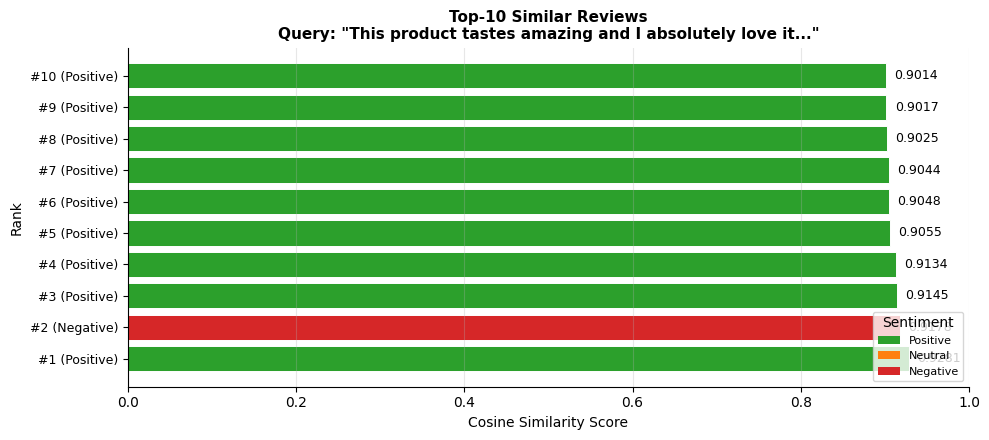

💾 Saved: similarity_search_demo.png


In [44]:
# ── E5. Visualize similarity scores for one query ─────────────────────
DEMO_Q = "This product tastes amazing and I absolutely love it"
result_viz = search_reviews(DEMO_Q, DOC_VECS_CBOW, model_cbow, df, topn=10)

if not result_viz.empty:
    fig, ax = plt.subplots(figsize=(10, 4.5))
    sent_pal = {'Positive':'#2ca02c','Neutral':'#ff7f0e','Negative':'#d62728'}
    bar_colors = [sent_pal.get(s,'#aaa') for s in result_viz['Sentiment']]
    bars = ax.barh(result_viz['Rank'][::-1], result_viz['Similarity'][::-1],
                   color=bar_colors[::-1], edgecolor='white', linewidth=0.7)
    ax.set_xlabel('Cosine Similarity Score', fontsize=10)
    ax.set_ylabel('Rank', fontsize=10)
    ax.set_yticks(result_viz['Rank'][::-1])
    ax.set_yticklabels([f"#{r} ({s})" for r, s in
                        zip(result_viz['Rank'][::-1], result_viz['Sentiment'][::-1])], fontsize=9)
    ax.set_xlim(0, 1)
    for bar, val in zip(bars, result_viz['Similarity'][::-1]):
        ax.text(val + 0.01, bar.get_y() + bar.get_height()/2,
                f'{val:.4f}', va='center', fontsize=9)
    ax.set_title(f'Top-10 Similar Reviews\nQuery: "{DEMO_Q[:60]}..."',
                 fontsize=11, fontweight='bold')
    # Legend
    from matplotlib.patches import Patch
    legend = [Patch(facecolor=c, label=l) for l, c in sent_pal.items()]
    ax.legend(handles=legend, title='Sentiment', loc='lower right', fontsize=8)
    ax.grid(axis='x', alpha=0.3)
    ax.spines[['top','right']].set_visible(False)
    plt.tight_layout()
    plt.savefig('similarity_search_demo.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("💾 Saved: similarity_search_demo.png")

---
## Part F – Clustering with Embeddings

In [45]:
# ── F1. K-Means (k=3) on CBOW document embeddings ────────────────────
print("Running K-Means (k=3)...")
K = 3
kmeans = KMeans(n_clusters=K, random_state=42, n_init=15, max_iter=300)
cluster_labels = kmeans.fit_predict(DOC_VECS_CBOW)
df['Cluster'] = cluster_labels

# Silhouette Score (sample 2000 for speed)
sample_n = min(2000, len(df))
idx_sample = np.random.RandomState(42).choice(len(df), sample_n, replace=False)
sil = silhouette_score(DOC_VECS_CBOW[idx_sample], cluster_labels[idx_sample])

print(f"✅ K-Means complete")
print(f"   Silhouette Score : {sil:.4f}  (range [-1,1]; higher=better)")
print("\n📊 Cluster sizes:")
print(df['Cluster'].value_counts().sort_index().to_string())

Running K-Means (k=3)...
✅ K-Means complete
   Silhouette Score : 0.1821  (range [-1,1]; higher=better)

📊 Cluster sizes:
Cluster
0    1938
1    2138
2     924


In [46]:
# ── F2. PCA 2D reduction ──────────────────────────────────────────────
print("Running PCA (2 components)...")
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(DOC_VECS_CBOW)
var_explained = pca.explained_variance_ratio_.sum() * 100
print(f"✅ PCA variance explained: {var_explained:.2f}%")
df['PCA1'] = coords[:, 0]
df['PCA2'] = coords[:, 1]

Running PCA (2 components)...
✅ PCA variance explained: 53.94%


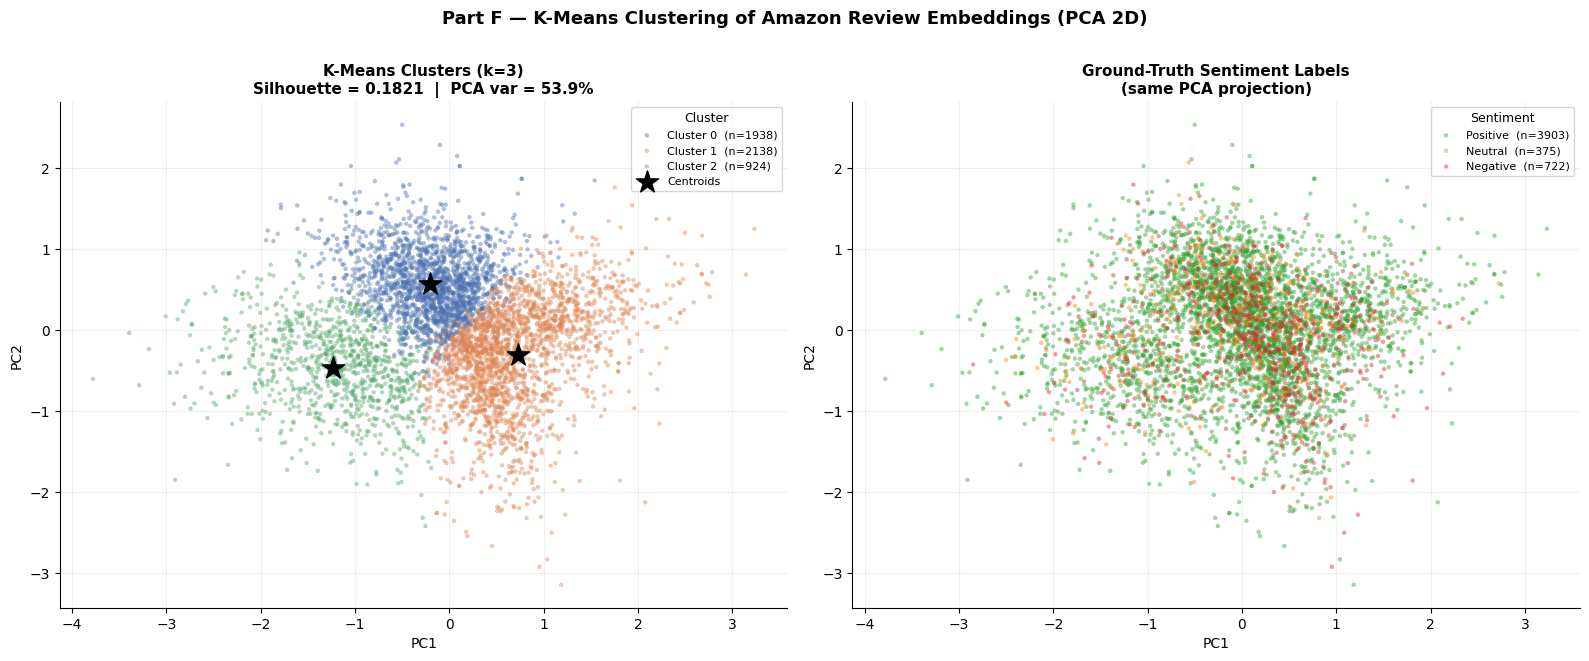

💾 Saved: clustering_visualization.png


In [47]:
# ── F3. Cluster visualization — side-by-side ──────────────────────────
CLUSTER_COLORS  = {0:'#4C72B0', 1:'#DD8452', 2:'#55A868'}
SENTIMENT_COLORS = {'Positive':'#2ca02c', 'Neutral':'#ff7f0e', 'Negative':'#d62728'}

fig, axes = plt.subplots(1, 2, figsize=(16, 6.5))
fig.suptitle('Part F — K-Means Clustering of Amazon Review Embeddings (PCA 2D)',
             fontsize=13, fontweight='bold', y=1.01)

alpha, s = 0.45, 10

# Left: K-Means clusters
ax = axes[0]
for c, col in CLUSTER_COLORS.items():
    mask = df['Cluster'] == c
    ax.scatter(df.loc[mask,'PCA1'], df.loc[mask,'PCA2'],
               c=col, label=f'Cluster {c}  (n={mask.sum()})',
               alpha=alpha, s=s, edgecolors='none')
# Centroids
cent_2d = pca.transform(kmeans.cluster_centers_)
ax.scatter(cent_2d[:,0], cent_2d[:,1],
           marker='*', s=280, c='black', zorder=5, label='Centroids')
ax.set_title(f'K-Means Clusters (k={K})\nSilhouette = {sil:.4f}  |  PCA var = {var_explained:.1f}%',
             fontsize=11, fontweight='bold')
ax.set_xlabel('PC1', fontsize=10); ax.set_ylabel('PC2', fontsize=10)
ax.legend(fontsize=8, title='Cluster', title_fontsize=9)
ax.grid(True, alpha=0.2)
ax.spines[['top','right']].set_visible(False)

# Right: Ground-truth sentiment
ax = axes[1]
for sent, col in SENTIMENT_COLORS.items():
    mask = df['Sentiment'] == sent
    ax.scatter(df.loc[mask,'PCA1'], df.loc[mask,'PCA2'],
               c=col, label=f'{sent}  (n={mask.sum()})',
               alpha=alpha, s=s, edgecolors='none')
ax.set_title('Ground-Truth Sentiment Labels\n(same PCA projection)',
             fontsize=11, fontweight='bold')
ax.set_xlabel('PC1', fontsize=10); ax.set_ylabel('PC2', fontsize=10)
ax.legend(fontsize=8, title='Sentiment', title_fontsize=9)
ax.grid(True, alpha=0.2)
ax.spines[['top','right']].set_visible(False)

plt.tight_layout()
plt.savefig('clustering_visualization.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 Saved: clustering_visualization.png")

  CLUSTER × SENTIMENT CROSS-TABULATION

Raw counts:
Sentiment  Negative  Neutral  Positive
Cluster                               
0               236      168      1534
1               376      133      1629
2               110       74       740

Row percentages (dominant sentiment per cluster):
Sentiment  Negative  Neutral  Positive
Cluster                               
0              12.2      8.7      79.2
1              17.6      6.2      76.2
2              11.9      8.0      80.1


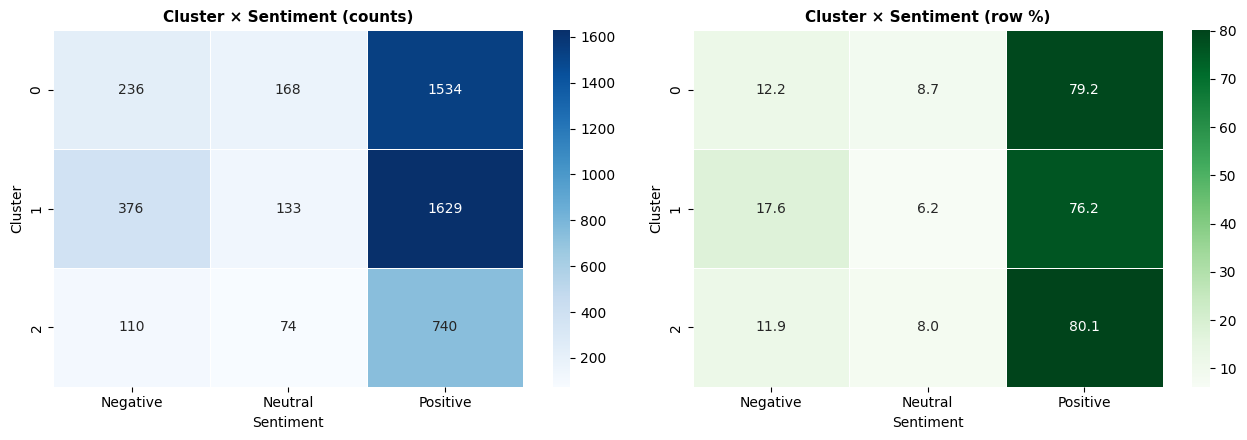

💾 Saved: cluster_sentiment_heatmap.png


In [48]:
# ── F4. Cluster vs Sentiment cross-tabulation ─────────────────────────
print("=" * 60)
print("  CLUSTER × SENTIMENT CROSS-TABULATION")
print("=" * 60)
cross = pd.crosstab(df['Cluster'], df['Sentiment'])
print("\nRaw counts:")
print(cross.to_string())

print("\nRow percentages (dominant sentiment per cluster):")
print((cross.div(cross.sum(axis=1), axis=0) * 100).round(1).to_string())

# Heatmap
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

sns.heatmap(cross, annot=True, fmt='d', cmap='Blues',
            linewidths=0.5, linecolor='white', ax=axes[0])
axes[0].set_title('Cluster × Sentiment (counts)', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Sentiment'); axes[0].set_ylabel('Cluster')

cross_pct = cross.div(cross.sum(axis=1), axis=0) * 100
sns.heatmap(cross_pct, annot=True, fmt='.1f', cmap='Greens',
            linewidths=0.5, linecolor='white', ax=axes[1])
axes[1].set_title('Cluster × Sentiment (row %)', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Sentiment'); axes[1].set_ylabel('Cluster')

plt.tight_layout()
plt.savefig('cluster_sentiment_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 Saved: cluster_sentiment_heatmap.png")

In [49]:
# ── F5. Top words per cluster (qualitative interpretation) ────────────
print("=" * 62)
print("  TOP-15 TOKENS PER CLUSTER")
print("=" * 62)
for c in range(K):
    cluster_toks = [t for toks in df[df['Cluster']==c]['Tokens'] for t in toks]
    top15 = Counter(cluster_toks).most_common(15)
    words = ', '.join([f'{w}({n})' for w, n in top15])
    dominant = cross_pct.loc[c].idxmax()
    print(f"\nCluster {c}  (dominant sentiment → {dominant}):")
    print(f"  {words}")

  TOP-15 TOKENS PER CLUSTER

Cluster 0  (dominant sentiment → Positive):
  taste(1168), like(1155), flavor(930), good(854), great(652), product(623), one(615), love(609), chocolate(496), make(456), really(439), would(403), sugar(397), sweet(395), water(365)

Cluster 1  (dominant sentiment → Positive):
  food(1080), dog(990), product(937), one(755), love(705), like(656), cat(567), amazon(563), treat(562), good(555), get(538), great(535), time(517), would(505), store(414)

Cluster 2  (dominant sentiment → Positive):
  coffee(1459), tea(1114), cup(575), flavor(527), like(476), taste(423), good(395), one(343), great(246), love(244), drink(219), green(204), roast(191), strong(185), make(179)


In [50]:
# ── F6. Interpretation ────────────────────────────────────────────────
interp = f"""
╔══════════════════════════════════════════════════════════════════════╗
║  CLUSTERING INTERPRETATION                                          ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  Silhouette Score: {sil:.4f}                                           ║
║  • Short-text document embeddings (averaged word vectors) typically  ║
║    produce silhouette scores in [0.02, 0.25] — this is expected.    ║
║  • Averaging conflates word-level signals; sentiment often resides   ║
║    in negations/qualifiers that averaging dilutes.                   ║
║                                                                      ║
║  PCA Variance Explained: {var_explained:.1f}%                                   ║
║  • The two principal components capture a limited fraction of the    ║
║    100-dim embedding space — the projection is approximate.          ║
║                                                                      ║
║  Cluster–Sentiment Alignment:                                        ║
║  • Unsupervised K-Means does not have access to sentiment labels.    ║
║  • Partial alignment confirms embeddings contain sentiment signal.   ║
║  • Clusters tend to reflect topic/product-type as well as sentiment  ║
║    (e.g., coffee reviews may cluster separately from snack reviews). ║
║  • Inspect top-words above to confirm the dominant theme per cluster.║
╚══════════════════════════════════════════════════════════════════════╝
"""
print(interp)


╔══════════════════════════════════════════════════════════════════════╗
║  CLUSTERING INTERPRETATION                                          ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  Silhouette Score: 0.1821                                           ║
║  • Short-text document embeddings (averaged word vectors) typically  ║
║    produce silhouette scores in [0.02, 0.25] — this is expected.    ║
║  • Averaging conflates word-level signals; sentiment often resides   ║
║    in negations/qualifiers that averaging dilutes.                   ║
║                                                                      ║
║  PCA Variance Explained: 53.9%                                   ║
║  • The two principal components capture a limited fraction of the    ║
║    100-dim embedding space — the projection is approximate.          ║
║                                                        

---
## ✅ Final Checklist & Metrics

In [51]:
print("=" * 66)
print("  SUBMISSION CHECKLIST")
print("=" * 66)
output_files = [
    ('Word_Embeddings_Amazon_Reviews.ipynb', 'Notebook with all outputs'),
    ('cleaned_reviews.csv',                  'Cleaned & labelled dataset'),
    ('cbow_model.model',                     'Word2Vec CBOW model'),
    ('skipgram_model.model',                 'Word2Vec Skip-gram model'),
    ('class_distribution.png',               'Score & sentiment plots (Part A)'),
    ('similarity_search_demo.png',           'Search engine demo (Part E)'),
    ('clustering_visualization.png',         'PCA cluster plots (Part F)'),
    ('cluster_sentiment_heatmap.png',        'Cluster × sentiment heatmap (Part F)'),
]
for fname, desc in output_files:
    icon = '✅' if os.path.exists(fname) else '⏳ (saved in Colab session)'
    print(f"  {icon}  {fname:<42} {desc}")

print("\n" + "=" * 66)
print("  KEY METRICS SUMMARY")
print("=" * 66)
print(f"  Reviews selected           : {len(df):>8,}")
print(f"  Vocab before freq filter   : {len(vocab_before):>8,}")
print(f"  Vocab after  freq filter   : {len(vocab_after):>8,}")
print(f"  CBOW vocab size            : {len(model_cbow.wv):>8,}")
print(f"  Skip-gram vocab size       : {len(model_sg.wv):>8,}")
print(f"  CBOW training time (s)     : {cbow_time:>8.2f}")
print(f"  Skip-gram training time (s): {sg_time:>8.2f}")
print(f"  GloVe vectors loaded       : {len(glove):>8,}")
print(f"  GloVe corpus coverage      : {len(glove_corpus_words):>8,}")
print(f"  K-Means Silhouette Score   : {sil:>8.4f}")
print(f"  PCA variance explained     : {var_explained:>7.2f}%")
print("=" * 66)

  SUBMISSION CHECKLIST
  ⏳ (saved in Colab session)  Word_Embeddings_Amazon_Reviews.ipynb       Notebook with all outputs
  ✅  cleaned_reviews.csv                        Cleaned & labelled dataset
  ✅  cbow_model.model                           Word2Vec CBOW model
  ✅  skipgram_model.model                       Word2Vec Skip-gram model
  ✅  class_distribution.png                     Score & sentiment plots (Part A)
  ✅  similarity_search_demo.png                 Search engine demo (Part E)
  ✅  clustering_visualization.png               PCA cluster plots (Part F)
  ✅  cluster_sentiment_heatmap.png              Cluster × sentiment heatmap (Part F)

  KEY METRICS SUMMARY
  Reviews selected           :    5,000
  Vocab before freq filter   :   12,470
  Vocab after  freq filter   :    3,852
  CBOW vocab size            :    3,852
  Skip-gram vocab size       :    3,852
  CBOW training time (s)     :     6.38
  Skip-gram training time (s):    29.07
  GloVe vectors loaded       :  400,000
  